In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
from collections import defaultdict
from collections import Counter
from PIL import Image
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping



In [2]:
path = kagglehub.dataset_download("mahmoudreda55/satellite-image-classification")
print("Path to dataset:", path)

Path to dataset: C:\Users\jli20\.cache\kagglehub\datasets\mahmoudreda55\satellite-image-classification\versions\1


In [3]:
def convert_all_to_rgb(directory):
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                with Image.open(file_path) as img:
                    if img.mode != 'RGB':
                        rgb_img = img.convert('RGB')
                        rgb_img.save(file_path)
            except Exception as e:
                print(f"Failed on {file_path}: {e}")

In [4]:
data_path = os.path.join(path, 'data')
subfolders = os.listdir(data_path)
print("Class folders:", subfolders)
convert_all_to_rgb(data_path)

Class folders: ['cloudy', 'desert', 'green_area', 'water']


In [5]:
img_size = (224, 224)
batch_size = 32

dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    image_size=img_size,
    batch_size=batch_size,
    color_mode='rgb'
)

unbatched_ds = dataset.unbatch()

class_names = dataset.class_names
print("Class names:", class_names)

Found 5631 files belonging to 4 classes.
Class names: ['cloudy', 'desert', 'green_area', 'water']


In [6]:
"""
{
  'cloudy': [(img1, lbl1), (img2, lbl2)]
  'desert': [.......]
  ......
}
"""

class_datasets = defaultdict(list)

for image, label in unbatched_ds:
    class_idx = int(label.numpy())
    class_name = class_names[class_idx]
    class_datasets[class_name].append((image, label))

In [7]:
def make_class_dataset(data_tuples, batch_size):
    imgs, labels = zip(*data_tuples)
    ds = tf.data.Dataset.from_tensor_slices((list(imgs), list(labels)))
    return ds.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
cloudy_ds = make_class_dataset(class_datasets["cloudy"], batch_size)
desert_ds = make_class_dataset(class_datasets["desert"], batch_size)
green_ds  = make_class_dataset(class_datasets["green_area"], batch_size)
water_ds  = make_class_dataset(class_datasets["water"], batch_size)

In [9]:
def count_images(dataset):
    return sum(1 for _ in dataset.unbatch())

In [10]:
print("Cloudy images:", count_images(cloudy_ds))
print("Desert images:", count_images(desert_ds))
print("Green images:", count_images(green_ds))
print("Water images:", count_images(water_ds))

Cloudy images: 1500
Desert images: 1131
Green images: 1500
Water images: 1500


In [11]:
for image, label in cloudy_ds.take(1):
    print("Min:", tf.reduce_min(image).numpy())
    print("Max:", tf.reduce_max(image).numpy())
    print("Mean:", tf.reduce_mean(image).numpy())

Min: 48.816326
Max: 255.0
Mean: 155.28891


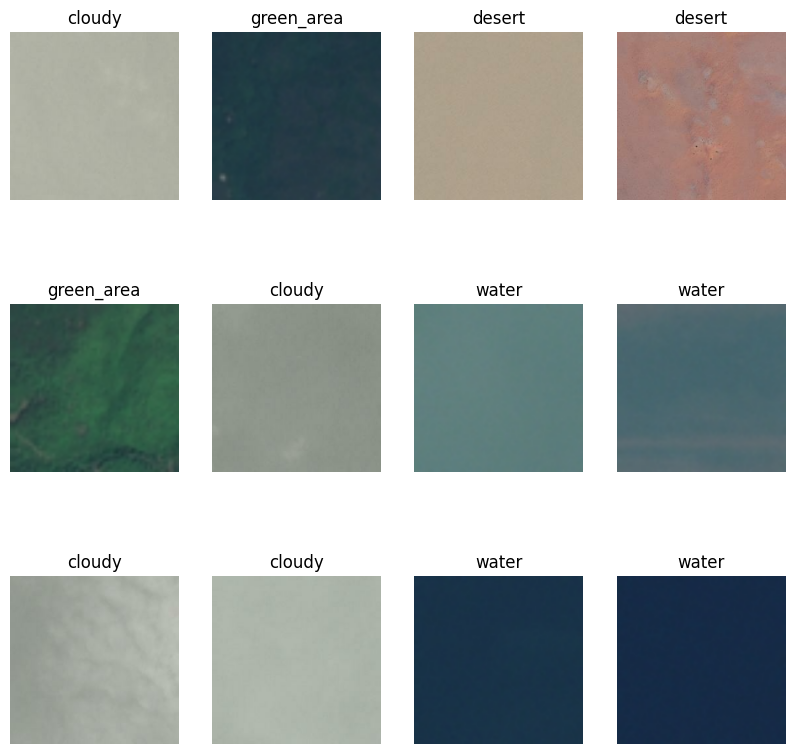

In [12]:
class_names = dataset.class_names

number_of_images = 12

plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):  # One batch
    for i in range(number_of_images):
        ax = plt.subplot(number_of_images//4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,      # 20% for validation
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Train images:", tf.data.experimental.cardinality(train_ds).numpy() * 16)
print("Val batches:", tf.data.experimental.cardinality(val_ds).numpy())
print("Val images:", tf.data.experimental.cardinality(val_ds).numpy() * 16)



Found 5631 files belonging to 4 classes.
Using 4505 files for training.
Found 5631 files belonging to 4 classes.
Using 1126 files for validation.
Train batches: 141
Train images: 2256
Val batches: 36
Val images: 576


In [14]:
def count_class_number(dataset):
    train_counter = Counter()

    for _, label in dataset.unbatch():
        train_counter[int(label.numpy())] += 1

    # Map class indices to names
    class_names = dataset.class_names
    train_distribution = {class_names[i]: count for i, count in train_counter.items()}

    print("Training set class distribution:")
    for k, v in train_distribution.items():
        print(f"{k}: {v}")

In [15]:
shuffled_cloudy = (
    cloudy_ds
    .unbatch()
    .shuffle(buffer_size=2000)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

shuffled_green = (
    green_ds
    .unbatch()
    .shuffle(buffer_size=2000)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

shuffled_desert = (
    desert_ds
    .unbatch()
    .shuffle(buffer_size=2000)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

shuffled_water = (
    water_ds
    .unbatch()
    .shuffle(buffer_size=2000)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

In [16]:
print(type(water_ds))
print(type(shuffled_water))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


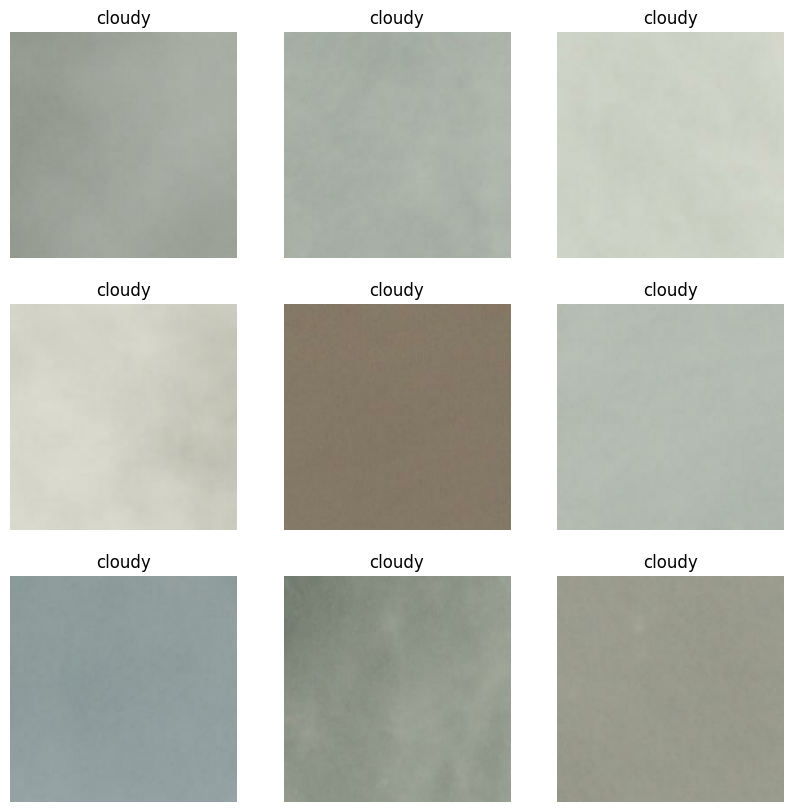

In [17]:
number_of_images = 9

plt.figure(figsize=(10, 10))
for images, labels in shuffled_cloudy.take(1):  # One batch
    for i in range(number_of_images):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i].numpy())])
        plt.axis("off")

In [18]:
pre_split_cloudy = list(shuffled_cloudy.unbatch())
pre_split_green = list(shuffled_green.unbatch())
pre_split_water = list(shuffled_water.unbatch())
pre_split_desert = list(shuffled_desert.unbatch())

In [19]:
def relabel(data, new_label):
    return [(img, tf.constant(new_label)) for (img, _) in data]

cloudy = relabel(pre_split_cloudy, 0)
desert = relabel(pre_split_cloudy, 1)
green  = relabel(pre_split_green, 2)
water  = relabel(pre_split_water, 3)

In [20]:
def dataset_split(data, train_ratio):
    i = int(len(data) * train_ratio)
    return data[:i], data[i:]

In [21]:
cloudy_train, cloudy_val = dataset_split(pre_split_cloudy, 0.8)
green_train, green_val = dataset_split(pre_split_green, 0.8)
water_train, water_val = dataset_split(pre_split_water, 0.8)
desert_train, desert_val = dataset_split(pre_split_desert, 0.8)


In [22]:
train_data = cloudy_train + desert_train + green_train + water_train
val_data   = cloudy_val + desert_val + green_val + water_val

In [23]:
def to_tf_dataset(data, batch_size):
    imgs, labels = zip(*data)
    ds = tf.data.Dataset.from_tensor_slices((list(imgs), list(labels)))
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [24]:
batch_size = 32
train_ds = to_tf_dataset(train_data, batch_size)
val_ds   = to_tf_dataset(val_data, batch_size)

In [25]:
train_ds = train_ds.shuffle(buffer_size=10000)
val_ds = val_ds.shuffle(buffer_size=5000)

In [42]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [43]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [44]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,        # reduce by half
    patience=3,        # after 3 epochs of no improvement
    verbose=1,
    min_lr=1e-6
)

In [39]:
early_stop = EarlyStopping(
    monitor='val_loss',         # or 'val_accuracy'
    patience=3,                 # wait for 3 epochs with no improvement
    restore_best_weights=True  # roll back to best weights
)

In [48]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[lr_scheduler],
)

Epoch 1/100


141/141 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.9175 - loss: 0.2053 - val_accuracy: 0.9068 - val_loss: 0.2456 - learning_rate: 6.2500e-05
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 106s 709ms/step - accuracy: 0.9102 - loss: 0.2166 - val_accuracy: 0.9059 - val_loss: 0.2425 - learning_rate: 6.2500e-05
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 109s 772ms/step - accuracy: 0.9102 - loss: 0.2215 - val_accuracy: 0.8926 - val_loss: 0.2513 - learning_rate: 6.2500e-05
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 111s 781ms/step - accuracy: 0.9185 - loss: 0.1987 - val_accuracy: 0.9095 - val_loss: 0.2319 - learning_rate: 6.2500e-05
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 108s 766ms/step - accuracy: 0.9175 - loss: 0.2051 - val_accuracy: 0.9113 - val_loss: 0.2326 - learning_rate: 6.2500e-05
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 110s 781ms/step - accuracy: 0.9119 - loss: 0.2115 - val_accuracy: 0.8900 - val_loss: 0.2567 - learning_rate: 6.2500e-05
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms

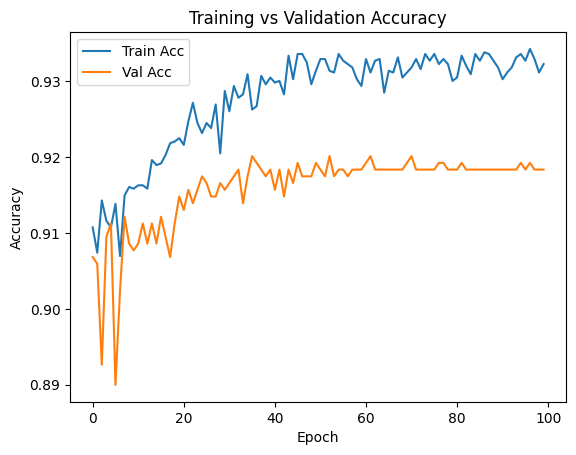

In [49]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

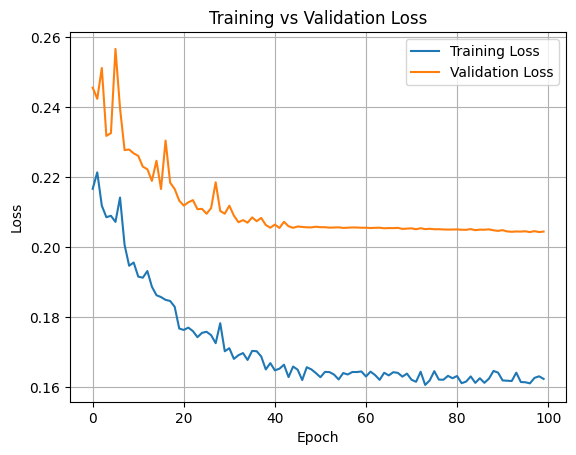

In [50]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()